# Milestone 2

### Mark Hill, Kyle Honegger, & Joseph Reilly

There are roughly 300,000 movies in TMDb, which should provide more than enough observations to build our training data.  While some of these are missing poster images which will limit our training data size, we feel at this point that we will not need to use the IMDb API extensively in our project.

Since many older movies appear to be missing poster data, we decided to download everything from 1940 through today that has a poster and at least one genre tag. Other data may still be missing but this is the bare minimum necessary to compare the performance of our classical and deep learning models on our predictions. This download is still in progress due to limitations of the number of API calls in a certain timeframe. To speed up the download, we are using several EC2 micro instances with unique IPs to split the download into several batches we can merge to form our training set. We've had some issues getting the EFS filesystem to mount on all instances when batch downloading across EC2 instances but the code we are running on AWS and to merge files is appended at the end of this notebook.

Our data includes the IMDB ID, genres, title, release date, plot summary, tagline, budget, revenue, popularity on TMDb, vote count, vote average, original language, production company, spoken language, run time, number of actors, number of crew, and whether the film is adult in nature. We selected as many continuous quantitative predictors as we could since most of our data is categorical. Tagline and summary can all be subjected to textual analysis and extant literature exists on genre prediction from similar analyses. Certain budget and revenue sizes are more typical of certain genres (Hollywood summer blockbuster versus artistic ballet documentary, for example.) Different genres are typically rated higher or lower, with drama typically on the high end and action on the lower side of the spectrum. Certain production countries and companies specialize in specific types of movie so this could potentially be a strong predictor of certain genres. Analysis for Milestone 3 will likely remove some of these fratures from consideration. Additionally, we plan on using PCA on all our features to attempt to reduce dimensionality of the problem. We will also attempt to fit a model using most of the principal components themselves as features as we did in Midterm 2 and a previous homework assignment. 

We're pursuing a multilabel classification strategy but are hesitant to include all current genres due to the large class imbalance between genres that is visualized below:

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import requests
import json
from imdb import IMDb
from collections import Counter

In [2]:
#load json file with 5000 movie subset
with open('data.txt') as json_file:  
    data = json.load(json_file)

In [4]:
import requests
CONFIG_PATTERN = 'http://api.themoviedb.org/3/configuration?api_key={key}'
KEY = '2b2fbe62128703d589c7c7ce18847e91'

#get genre movie list from TMDb (to convert ID to name of genre)
LIST = 'https://api.themoviedb.org/3/genre/movie/list?api_key={key}&language=en-US'
r = requests.get(LIST.format(key=KEY))
genre_list = r.json()

#make it a dictionary
dict = {}
for i in range(len(genre_list['genres'])):
    dict[genre_list['genres'][i]['id']] = genre_list['genres'][i]['name']

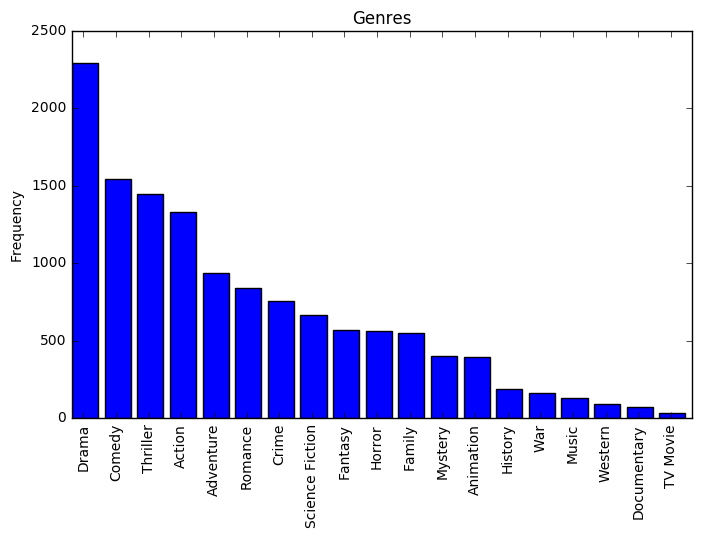

In [7]:
#look at genre class imbalance

#convert genre IDs to names
genres = []
for i in range(len(data['movies'])):
    for j in range(len(data['movies'][i]['genre_ids'])):
        genres.append(dict[data['movies'][i]['genre_ids'][j]])

counts = Counter(genres)
labels, values = zip(*counts.items())

# sort values in descending order
indSort = np.argsort(values)[::-1]

# rearrange data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.figure(figsize=(8,5))
plt.bar(indexes, values)
plt.xticks(indexes + bar_width, labels, rotation = 90)
plt.title("Genres")
plt.ylabel("Frequency")
plt.axis([0, 19, 0, 2500])

plt.show()

When visualizing the single genres from our subset, the class imbalance becomes apparent. "Drama" describes nearly half our movies while everything after "Family" are each present in less than 10% of our samples films. Left unaddressed, our model would likely overassign these more common classes while being highly inaccurate on the less represented classes. Instead of using accuracy as our performance metric, we could use ROC curves, F-score, or a metric like Cohen's kappa that accounts for class imbalance in classification tasks.

Considering our exploration of genre pairs from Milestone 1, several genre pairs like Action/Adventure and Family/Animation are fairly common and are highly correlated. Other genres like "Thriller" and "TV Movie" appear with many other genres and would be very difficult to discern.

We propose the following collapsed labels:

If genre label contains:<br>
action, adventure, fantasy, sci-fi, thriller, western --> action<br>
crime, drama, mystery, music, history, war --> drama<br>
family, animation --> family<br>
comedy --> comedy<br>
romance --> romance<br>
documentary --> documentary<br>
horror --> horror<br>

This clustering was adapted from a scheme implemented in:
Ivasic-Kos, M., Pobar, M., & Mikec, L. (2014, May). Movie posters classification into genres based on low-level features. In Information and Communication Technology, Electronics and Microelectronics (MIPRO), 2014 37th International Convention on (pp. 1198-1203). IEEE.

This will result in at least one genre tag for every movie while eliminating niche genres that would be extremely difficult to predict at scale. While still being a multi-label classification task, this will hopefully improve the predictive power of our model. "Documentary" will still be vastly under-represented as a class but it is a genre tag that often appears alone in movie descriptions.

To combat the class imbalance for algorithm training purposes, we could sample within our sample or construct a synthesic sample with more balanced genres.

## Code to run on AWS to scrape movie data

In [ ]:
import sys
import time
import numpy as np
import pandas as pd
import requests
import urllib


"""
These are the possible features to include that are taken directly from the db.
Derived features (such as # actors) are calculated on the fly below.


DISCOVER returns:
----------------
poster_path
adult
overview
release_date
genre_ids
id
original_title
original_language
title
backdrop_path
popularity
vote_count
video
vote_average


MOVIE:
----------------
adult
backdrop_path
belongs_to_collection
budget
genres
    id
    name
homepage
id
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


POSTER SIZES:
--------------
w92
w154
w185
w342
w500
w780
original
"""


def timeout(t_marker=0, min_wait=0.251):
    while time.time() - t_marker < min_wait:
        pass


# Since the API will only allow a max page value of 1000,
# we need to break down by year and page to retrieve specific pages

LOAD_IDX = int(sys.argv[1]) # instance index from EC2 batch

# Have to hardcode the boundaries across instances for efficiency
IDX_KEY =   [[1941.0, 1946.0, 1.0, 11.0],
             [1946.0, 1951.0, 12.0, 27.0],
             [1951.0, 1955.0, 28.0, 46.0],
             [1955.0, 1959.0, 47.0, 30.0],
             [1959.0, 1962.0, 31.0, 71.0],
             [1962.0, 1966.0, 72.0, 4.0],
             [1966.0, 1968.0, 5.0, 67.0],
             [1968.0, 1970.0, 68.0, 109.0],
             [1970.0, 1973.0, 110.0, 30.0],
             [1973.0, 1975.0, 31.0, 66.0],
             [1975.0, 1978.0, 67.0, 3.0],
             [1978.0, 1980.0, 4.0, 36.0],
             [1980.0, 1982.0, 37.0, 67.0],
             [1982.0, 1984.0, 68.0, 91.0],
             [1984.0, 1986.0, 92.0, 107.0],
             [1986.0, 1988.0, 108.0, 105.0],
             [1988.0, 1990.0, 106.0, 90.0],
             [1990.0, 1992.0, 91.0, 84.0],
             [1992.0, 1994.0, 85.0, 76.0],
             [1994.0, 1996.0, 77.0, 52.0],
             [1996.0, 1998.0, 53.0, 8.0],
             [1998.0, 1999.0, 9.0, 104.0],
             [1999.0, 2000.0, 105.0, 185.0],
             [2000.0, 2002.0, 186.0, 39.0],
             [2002.0, 2003.0, 40.0, 62.0],
             [2003.0, 2004.0, 63.0, 57.0],
             [2004.0, 2005.0, 58.0, 14.0],
             [2005.0, 2005.0, 15.0, 276.0],
             [2005.0, 2006.0, 277.0, 194.0],
             [2006.0, 2007.0, 195.0, 85.0],
             [2007.0, 2007.0, 86.0, 347.0],
             [2007.0, 2008.0, 348.0, 224.0],
             [2008.0, 2009.0, 225.0, 71.0],
             [2009.0, 2009.0, 72.0, 333.0],
             [2009.0, 2010.0, 334.0, 158.0],
             [2010.0, 2010.0, 159.0, 420.0],
             [2010.0, 2011.0, 421.0, 227.0],
             [2011.0, 2011.0, 228.0, 489.0],
             [2011.0, 2012.0, 490.0, 253.0],
             [2012.0, 2012.0, 254.0, 515.0],
             [2012.0, 2013.0, 516.0, 231.0],
             [2013.0, 2013.0, 232.0, 493.0],
             [2013.0, 2014.0, 494.0, 144.0],
             [2014.0, 2014.0, 145.0, 406.0],
             [2014.0, 2015.0, 407.0, 17.0],
             [2015.0, 2015.0, 18.0, 279.0],
             [2015.0, 2015.0, 280.0, 541.0],
             [2015.0, 2016.0, 542.0, 197.0],
             [2016.0, 2016.0, 198.0, 459.0],
             [2016.0, 2017.0, 460.0, 172.0]]

START_YEAR = int(IDX_KEY[LOAD_IDX][0])
END_YEAR = int(IDX_KEY[LOAD_IDX][1])
START_PAGE = int(IDX_KEY[LOAD_IDX][2])
END_PAGE = int(IDX_KEY[LOAD_IDX][3])

yr_range = range(START_YEAR, END_YEAR+1)

KEY = '2b2fbe62128703d589c7c7ce18847e91'
POSTERSIZE = 185
VERBOSE = True

include_features = ['id',
                    'genres',
                    'imdb_id',
                    'title',
                    'original_title',
                    'release_date',
                    'overview',
                    'tagline',
                    'budget',
                    'revenue',
                    'popularity',
                    'vote_count',
                    'vote_average',
                    'original_language',
                    'production_companies',
                    'production_countries',
                    'spoken_languages',
                    'runtime',
                    'adult',
                    'n_actors',
                    'n_crew']

fulldf = None

for year in yr_range:

    INFO = 'https://api.themoviedb.org/3/discover/movie?api_key={key}&primary_release_year={year}'
    r = requests.get(INFO.format(key=KEY, year=year))
    t = time.time()
    api_response = r.json()

    if year > yr_range[0]:
        START_PAGE = 1

    if year < yr_range[-1]:
        END_PAGE = api_response['total_pages']
    else:
        END_PAGE = int(IDX_KEY[LOAD_IDX][3])

    for thispage in range(START_PAGE, END_PAGE+1):

        INFO = 'https://api.themoviedb.org/3/discover/movie?api_key={key}&primary_release_year={year}&page={page}'
        timeout(t)
        r = requests.get(INFO.format(key=KEY, year=year, page=thispage))
        t = time.time()
        api_response = r.json()


        for movie in api_response['results']:

            if VERBOSE:
                print movie['id']

            # If it doesn't have poster or genre data, skip it
            if (len(movie['genre_ids']) < 1 or movie['poster_path'] == None):
                if VERBOSE:
                    print 'skipped', movie['id']

            else:
                try:
                    # Download poster to '/posters/' directory with name: 'ID.jpg'
                    POSTER = 'https://image.tmdb.org/t/p/w{posterSz}{posterID}'
                    urllib.urlretrieve(POSTER.format(posterSz=POSTERSIZE, posterID=movie['poster_path']),
                                       './posters/' + str(movie['id']) + '.jpg')

                    # Retrieve full movie data from new query
                    MOVIE = 'https://api.themoviedb.org/3/movie/{movie}?api_key={key}'
                    timeout(t)
                    r = requests.get(MOVIE.format(key=KEY, movie=movie['id']))
                    t = time.time()
                    movie_response = r.json()

                    # Retrieve movie cast info
                    CAST = 'https://api.themoviedb.org/3/movie/{movie}/credits?api_key={key}'
                    timeout(t)
                    r = requests.get(CAST.format(key=KEY, movie=movie['id']))
                    t = time.time()
                    cast_response = r.json()

                    # Since we're converting the df to text anyways, we can just interpret everything as categorical
                    tmp = []
                    for feature in include_features:

                        # Some features need to be retrieved by key and need special handling, separate values by '~'
                        if feature == 'genres':
                            tmp.append('~'.join([str(x['id']) for x in movie_response['genres']]))
                        elif feature == 'production_companies':
                            tmp.append('~'.join([str(x['id']) for x in movie_response['production_companies']]))
                        elif feature == 'production_countries':
                            tmp.append('~'.join([str(x['iso_3166_1']) for x in movie_response['production_countries']]))
                        elif feature == 'spoken_languages':
                            tmp.append('~'.join([str(x['iso_639_1']) for x in movie_response['spoken_languages']]))
                        elif feature == 'n_actors':
                            tmp.append(str(len(cast_response['cast'])))
                        elif feature == 'n_crew':
                            tmp.append(str(len(cast_response['crew'])))
                        else:
                            tmp.append(movie_response[feature])

                    # Populate df with movie info
                    if fulldf is None:
                        fulldf = pd.DataFrame(tmp, index=include_features)
                    else:
                        fulldf = pd.concat([fulldf, pd.Series(tmp, index=include_features)], axis=1)

                except:
                    print 'something bad happened...'


# Stitch data into csv row, using pipe as a delimiter
print 'Done retrieving data.  Saving to file...'
fulldf = fulldf.transpose()

if LOAD_IDX < 10:
    LOAD_IDX = '0' + str(LOAD_IDX)

fulldf.to_csv('./TMDB_raw_data_{IDX}.csv'.format(IDX=LOAD_IDX), '|', index=False, encoding='utf8')
print 'Done.'

## Code to combine .csv files into labeled training data set

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
# iterate over all .csv files in directory and append them into one large file
i=0
for file in os.listdir(os.getcwd()):
    if file.endswith(".csv"):
        if i==0:
            train_data = pd.read_csv(file, sep='|')
            i+=1
        else:
            temp = pd.read_csv(file, sep='|')
            train_data = train_data.append(temp, ignore_index=True)        

In [ ]:
# for each column that stores multiple values as a string separated by '~'
# split that string apart and store the name of that column to be broken into dummies
dummy_names = []
for name in list(train_data):
    if train_data[name].dtype == 'O' and sum(train_data[name].str.contains('~'))!=0:
        train_data[name] = train_data[name].str.split('~')
        dummy_names.append(name)

In [ ]:
# for each column that was split on '~' except for genre make dummy variables for each
# unique value and concatenate to original data frame
for name in dummy_names:
    if name == 'genres':
        temp = train_data['genres'].str.join(sep='*').str.get_dummies(sep='*')
        labels = ['Unlabeled']*temp.shape[0]
        for i in range(temp.shape[0]):
            if np.sum(temp.loc[i,['28','12','14','878','53','37']]) != 0:
                labels[i] = 'Action'
            if np.sum(temp.loc[i,['80','18','9648','10402','36','10752']]) != 0:
                labels[i] = 'Drama'
            if np.sum(temp.loc[i,['35']]) != 0:
                labels[i] = 'Comedy'
            if np.sum(temp.loc[i,['10751','16']]) != 0:
                labels[i] = 'Family'
            if np.sum(temp.loc[i,['10749']]) != 0:
                labels[i] = 'Romance'
            if np.sum(temp.loc[i,['99']]) != 0:
                labels[i] = 'Documentary'
            if np.sum(temp.loc[i,['27']]) != 0:
                labels[i] = 'Horror'
        
        labels = pd.DataFrame(labels)
        labels.columns = ['Labels']
    else:
        temp = train_data[name].str.join(sep='*').str.get_dummies(sep='*')
        temp.columns = [name + '_' + str(col) for col in temp.columns]
        train_data = pd.concat([train_data.reset_index(drop=True), temp], axis=1)

In [ ]:
train_data = train_data.drop('genres', axis=1)

In [ ]:
Y = labels